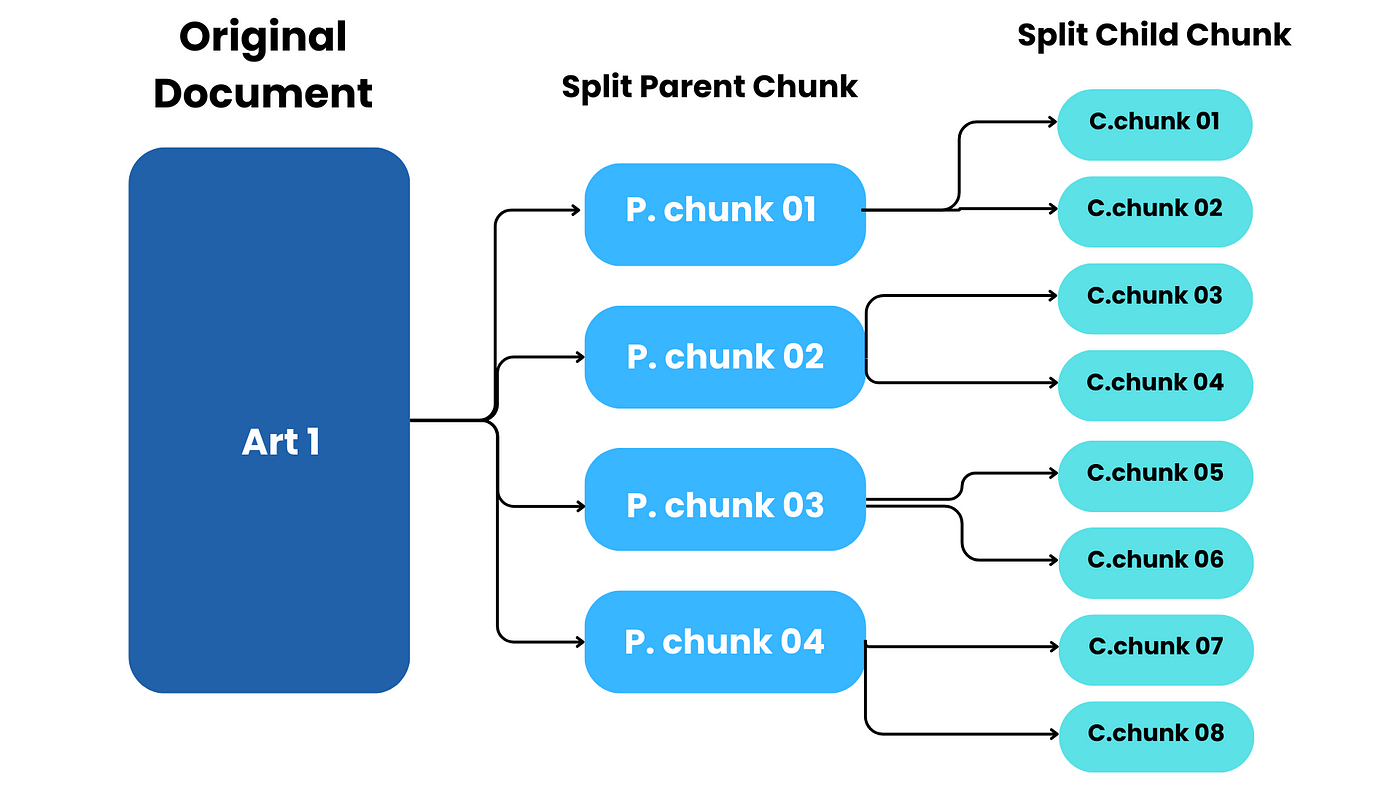

### Installing dependencies

In [53]:
!pip install -U "langchain==0.0.344" "openai==0.28" tiktoken lark datasets sentence_transformers FlagEmbedding lancedb -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.1.23 requires langchain-core<0.3.0,>=0.2.35, but you have langchain-core 0.0.13 which is incompatible.
langchain-openai 0.1.23 requires openai<2.0.0,>=1.40.0, but you have openai 0.28.0 which is incompatible.
langchain-text-splitters 0.2.4 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.0.13 which is incompatible.


### Importing libraries

In [54]:
from langchain.vectorstores import LanceDB
from langchain.retrievers import ParentDocumentRetriever

# Text Splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.docstore.document import Document

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

import os
from datasets import load_dataset

from langchain.embeddings import HuggingFaceBgeEmbeddings
import lancedb

In [42]:
os.environ["OPENAI_API_KEY"] = "sk-proj-...."  # NEEDED if you run LLM Experiment below

### Embeddings

In [4]:
# Embedding Functions
model_name = "BAAI/bge-small-en-v1.5"  # Open Source and effective Embedding
encode_kwargs = {"normalize_embeddings": True}  # set True to compute cosine similarity
bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs={"device": "cuda"}, encode_kwargs=encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Chunk the data

In [5]:
# Data Chunking Functions
small_chunk_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512
)  # Splitter to split documents into small chunks
big_chunk_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2048
)  # Another Level of Bigger Chunks

## LanceDB connection

In [6]:
# Lance DB Connection. Load if exists else create
my_db = lancedb.connect("./my_db")

# Load [Eminem Lyrics Dataset](https://huggingface.co/huggingartists/eminem)

Convert it to a `LangChain` Documents

In [7]:
# Load a sample data here
long_texts = (
    load_dataset("huggingartists/eminem")["train"].to_pandas().sample(100)["text"]
)  # Data of huge context length. Use 100 random examples for demo

# Convert to LangChain Document object
docs = [
    Document(page_content=content, doc_id=_id, metadata={"doc_id": _id})
    for (_id, content) in enumerate(long_texts)
]  # List of LangChain Document Objects

Generating train split:   0%|          | 0/1285 [00:00<?, ? examples/s]

# Method 1: Retrieve Parent Document

When you run a Query, match it against the **smaller** chunks and retrieve it's Parent Document for passing to LLM as a context

In [8]:
!rm -rf ./my_db

In [9]:
if "small_chunk_table" in my_db.table_names():
    small_chunk_table = my_db.open_table("small_chunk_table")
else:  # NOTE: 384 is the size of BAAI Embedding and -999 because it's a dummy data so invalid Embedding
    small_chunk_table = my_db.create_table(
        "small_chunk_table",
        data=[
            {
                "vector": [-999] * 384,
                "text": "",
                "doc_id": "-1",
            }
        ],
        mode="overwrite",
    )

small_chunk_table.delete('doc_id = "-1"')

vectorstore = LanceDB(
    small_chunk_table, bge_embeddings
)  # Vectorstore to use to index the child chunks
store = InMemoryStore()  # The storage layer for the parent documents

full_doc_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore, docstore=store, child_splitter=small_chunk_splitter
)

full_doc_retriever.add_documents(docs, ids=None)  # Add all the documents

In [10]:
# Fetch 3 most similar Smaller Documents
sub_docs = vectorstore.similarity_search(
    "I am whatever you say I am and if I wasn't why would you say I am", k=3
)

print(sub_docs[0].page_content)  # This is a Smaller Chunk

You are a true Queen, and I mean that in every sense of the word. I will never forget the opportunities you have given me. You will always be in my heart, my thoughts, and my prayers. As I have said before, you have no idea how much your son and his music has inspired, not only the Hip Hop world, but, speaking for myself, has inspired my whole career. He was, and still is, the true definition of a Soldier. When I was feeling at my worst; I knew I could put that 2Pac tape in, and suddenly, things werent so


In [11]:
full_docs = full_doc_retriever.get_relevant_documents(
    "I am whatever you say I am and if I wasn't why would you say I am", k=3
)
print(
    full_docs[0].page_content
)  # This is the Parent Document returned after matching the smaller chunks internally

Letter to Tupac’s Mother LyricsDear Afeni
Sorry if it looks a little sloppy, I couldve done a little better if I had the right pencils. Instead, I had to draw it in pen. Plus, I just kind of thought of the idea a little too late. But Ive been drawing since I was 10, and I thought you might like it. Anyways, thank you for always being so kind to me. You are a true Queen, and I mean that in every sense of the word. I will never forget the opportunities you have given me. You will always be in my heart, my thoughts, and my prayers. As I have said before, you have no idea how much your son and his music has inspired, not only the Hip Hop world, but, speaking for myself, has inspired my whole career. He was, and still is, the true definition of a Soldier. When I was feeling at my worst; I knew I could put that 2Pac tape in, and suddenly, things werent so bad. He gave me the courage to stand up and say Fk the world! This is who I am! And if you dont like it, go fk yourself! Thank you for giv

#  Method 2: Retrieving Larger chunks

If, small chunks are not needed as they don't have the whole context BUT the full documents are too big to be needing or fitting into LLM, we split the raw documents into larger chunks, and then split it into smaller chunks. Then index the smaller chunks, but on retrieval we retrieve the larger chunks as a replacement of full documents.

In [12]:
if "big_chunk_table" in my_db.table_names():
    big_chunk_table = my_db.open_table("big_chunk_table")
else:
    big_chunk_table = my_db.create_table(
        "big_chunk_table",
        data=[
            {
                "vector": [-999] * 384,
                "text": "",
                "doc_id": "-1",
            }
        ],
        mode="overwrite",
    )

big_chunk_table.delete('doc_id = "-1"')

vectorstore = LanceDB(big_chunk_table, bge_embeddings)
store = InMemoryStore()

big_chunk_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=small_chunk_splitter,
    parent_splitter=big_chunk_splitter,
)  # See one more line addition which retrieves the larger chunk instead of Parent Document

big_chunk_retriever.add_documents(docs, ids=None)  # Add all the documents

In [13]:
big_chunks_docs = big_chunk_retriever.get_relevant_documents(
    "I am whatever you say I am and if I wasn't why would you say I am", k=3
)
print(
    big_chunks_docs[0].page_content
)  # This is the BIG chunks (in place of Parent Document) returned after matching the smaller chunks internally

Letter to Tupac’s Mother LyricsDear Afeni
Sorry if it looks a little sloppy, I couldve done a little better if I had the right pencils. Instead, I had to draw it in pen. Plus, I just kind of thought of the idea a little too late. But Ive been drawing since I was 10, and I thought you might like it. Anyways, thank you for always being so kind to me. You are a true Queen, and I mean that in every sense of the word. I will never forget the opportunities you have given me. You will always be in my heart, my thoughts, and my prayers. As I have said before, you have no idea how much your son and his music has inspired, not only the Hip Hop world, but, speaking for myself, has inspired my whole career. He was, and still is, the true definition of a Soldier. When I was feeling at my worst; I knew I could put that 2Pac tape in, and suddenly, things werent so bad. He gave me the courage to stand up and say Fk the world! This is who I am! And if you dont like it, go fk yourself! Thank you for giv

# Dummy LLM Use

In [57]:
qa = RetrievalQA.from_chain_type(
    llm=OpenAI(model_name="gpt-4"),
    chain_type="stuff",
    retriever=big_chunk_retriever,
)

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:244: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:1043: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [58]:
query = (
    "I am whatever you say I am and if I wasn't why would you say I am? So who is Em?"
)
result = qa({"query": query})

In [61]:
result["result"]

'Em refers to Eminem, the rapper. His real name is Marshall Mathers, as indicated in the "Letter to Tupac’s Mother Lyrics". Eminem often refers to himself as "Em" in his music.'